# Практика №2

На прошлой практике мы реализовали DTW алгоритм. Он очень хорош и вроде как даже где-то применяется. Но у него есть существенные недостатки:

1) Для распознавания какого-либо слова необходимо иметь заранее подготовленные эталонные записи. Из этого вытекает проблема масштабирования системы с большим словарем.<br>
2) Подобная система имеет плохую устойчивость к шумам.<br>
3) По какому принципу вибирать нужные эталоны?<br>
4) Сколько должно быть таких эталонов, чтобы покрыть всю вариативность произнесеней?<br>
5) Чем больше эталонов, тем алгоритм вычислительнозатратен.<br>

В этом уроке мы перейдем от DTW к распознаванию по эталонному словарю. 

Эталон в графе теперь будет задаваться как последовательность фонем из словаря. Словарь для YES_NO (data/lexicon_yes_no.txt) выглядит следующим образом:

<b>YES</b>  SIL Y EH1 S SIL<br>
<b>NO</b>  SIL N OW1 SIL<br>

Словарь для цифр (data/lexicon_digits.txt):

<b>ZERO</b>  SIL Z IH1 R OW0 SIL<br>
<b>ZERO</b>  SIL Z IY1 R OW0 SIL<br>
<b>ONE</b>  SIL W AH1 N SIL<br>
<b>ONE</b>  SIL HH W AH1 N SIL<br>
<b>TWO</b>  SIL T UW1 SIL<br>
<b>THREE</b>  SIL TH R IY1 SIL<br>
<b>FOUR</b>  SIL F AO1 R SIL<br>
<b>FIVE</b>  SIL F AY1 V SIL<br>
<b>SIX</b>  SIL S IH1 K S SIL<br>
<b>SEVEN</b>  SIL S EH1 V AH0 N SIL<br>
<b>EIGHT</b>  SIL EY1 T SIL<br>
<b>NINE</b>  SIL N AY1 N SIL<br>

SIL здесь – это фонема паузы.
Как вы возможно заметили, для некторых слов имеется несколько вариантов фонемной транскрипции. Это позволяет лучше учесть фонетическое разнообразие в произнесении некоторых слов.

Каждой фонеме будет сопоставлен наиболее типичный для нее вектор признаков. В данном случае мы будем использовать среднее значение вектора признаков фонем, взятых из обучающего набора. Будем называть это акустической моделью.

### Данные для обучения

Наша задача собрать статистику акустических признаков по каждой фонеме, находящейся в графе распознавания. В качестве обучающей выборки мы будем использовать подмножество данных librispeech (аудиозаписи чтения книг на английском). Для этого предварительно мной была получена покадровая разметка этого подмножества на фонемы. Схематично данный процесс представлен на картинке ниже:

![](https://drive.google.com/uc?export=view&id=16PdwggV_Cl6aaD4cu1MZ-fKzWzAvcFVw)

Файл разметки (ali_phones.txt) представлен в формате:

<b>filename1 phone_frame1 phone_frame2 phone_frame3 ...<br>
   filename2 phone_frame1 phone_frame2 phone_frame3 ...</b> 
   
Пример такой покадровой фонемной разметки одного файла с текстом "<b>MUCH COULD BE DONE IN THREE YEARS</b>" представлен ниже:

<b>1183-124566-0003 SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL M M M M M M M M M AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 CH CH CH CH CH CH CH CH CH CH CH K K K K
K K K K K UH1 UH1 UH1 UH1 D D D D D B B B B B B IY0 IY0 IY0 IY0 IY0 D D D D D D D D D D D D AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 N N
N N N N N N N N N N N N N SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SI
L SIL SIL SIL SIL SIL SIL SIL SIL IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 N N N N N N N N N N SIL SIL SIL SIL SIL TH TH TH TH TH TH TH TH TH TH TH TH TH R R R R R R IY1 IY1
 IY1 IY1 IY1 IY1 IY1 Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 R R R R R R R R R R R R R R R Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z SIL SIL SIL SIL</b>
 
Аудио файлы этих данных лежат в папке "data/train_librispeech_10h/wav_dir"

### Bootstrap

In [1]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 162MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:16<00:00, 42.0MB/s]


In [2]:
!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv train_librispeech_10h lab2/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab2

/content/lab2


In [3]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display



%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# рассмотрим пример такой записи:
wav_example = 'data/train_librispeech_10h/wav_dir/1183-124566-0003.flac'

# чтение wav файла:
x, sr = librosa.load(wav_example, sr=None)     # sr=None to preserve the native sampling rate

print(f'Number of samples: {len(x)}')
print(f'Sampling rate: {sr} Hz')
print(f'Duration: {len(x)/sr:.2f} s')  # ~ librosa.get_duration(x, sr)

# воспроизведение:
ipd.Audio(x, rate=sr)

Number of samples: 45680
Sampling rate: 16000 Hz
Duration: 2.85 s


Text(0.5, 1.0, 'Log-frequency power spectrogram')

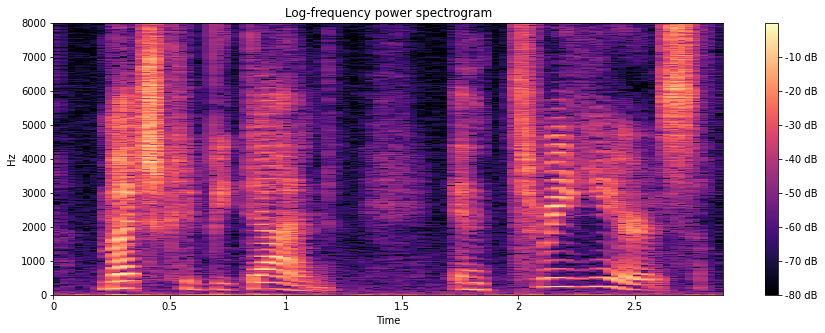

In [5]:
# спектрограмма:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
plt.figure(figsize=(15,5))
librosa.display.specshow(D, sr=sr, y_axis='hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

### Подготовка данных

In [6]:
# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

In [21]:
# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    for step, wav_name in tqdm(enumerate(os.listdir(dir_path))):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict

train_records_dir = 'data/train_librispeech_10h/wav_dir'
train_data_dict = load_data_dict(train_records_dir, count=1000)

0it [00:00, ?it/s]

Early stop at 1000th file..


In [22]:
# инициализация списка допустимых фонем из предустановленного файла
def init_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for line in fn:
            phones_dict[line.strip()] = []
    return phones_dict

phones_file = 'data/train_librispeech_10h/phones'
phones_dict = init_phones_dict(phones_file)

In [23]:
# присвоим каждой фонеме набор ее признаков в соответствии с фонемной разметкой обучающей выборки
# количество кадров признаков может немного отличаться от количества размеченных фонем
# это связано с особенностми построения разметки в Kaldi
for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])
        
# выведем статистику по кадой фонеме (некоторые фонемы вообще не используются, это особенности разметки в Kaldi):
count = 0
for phone in phones_dict.keys():
    if len(phones_dict[phone]) == 0:
        count +=1
    print(f'{phone:<3}: {len(phones_dict[phone])}')
print(f'Number of empty phones is: {count}')

SIL: 226955
SPN: 6318
AA : 0
AA0: 417
AA1: 18027
AA2: 911
AE : 0
AE0: 450
AE1: 36712
AE2: 1028
AH : 0
AH0: 55863
AH1: 19090
AH2: 443
AO : 0
AO0: 262
AO1: 20137
AO2: 579
AW : 0
AW0: 88
AW1: 11307
AW2: 495
AY : 0
AY0: 352
AY1: 30736
AY2: 1854
B  : 15535
CH : 8732
D  : 40234
DH : 20450
EH : 0
EH0: 530
EH1: 29007
EH2: 972
ER : 0
ER0: 25318
ER1: 9380
ER2: 142
EY : 0
EY0: 218
EY1: 24387
EY2: 1387
F  : 24103
G  : 8479
HH : 21467
IH : 0
IH0: 26223
IH1: 22743
IH2: 918
IY : 0
IY0: 21937
IY1: 23644
IY2: 584
JH : 6258
K  : 30385
L  : 43725
M  : 31399
N  : 59500
NG : 13323
OW : 0
OW0: 2098
OW1: 19770
OW2: 814
OY : 0
OY0: 12
OY1: 2704
OY2: 6
P  : 21605
R  : 40375
S  : 67193
SH : 13221
T  : 64287
TH : 7809
UH : 0
UH0: 14
UH1: 4049
UH2: 71
UW : 0
UW0: 982
UW1: 15988
UW2: 372
V  : 17896
W  : 24088
Y  : 6711
Z  : 33325
ZH : 574
Number of empty phones is: 15


In [24]:
# соберем статистику на основе среднего значения для каждой фонемы
mean_phones_value = {}
for phone in phones_dict.keys():
    if phones_dict[phone]:
        mean_phones_value[phone] = np.mean(phones_dict[phone], axis=0)

In [25]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание2)
#-----------------------------------------------------------------------

from sklearn.mixture import GaussianMixture


gmm_phones = {}
for phone in tqdm(phones_dict.keys()):
    if phones_dict[phone]:
        gm = GaussianMixture(
            n_components=3, 
            covariance_type='diag', 
            tol=1e-4,
            max_iter=200,
            random_state=0
        ).fit(phones_dict[phone])
        gmm_phones[phone] = gm

  0%|          | 0/86 [00:00<?, ?it/s]

### Инициализация фонемного графа

In [26]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)

Узлы графа теперь представляют собой отдельные фонемы с переходом только в себя и следующий узел (переходов через несколько узлов уже не будет, так как пропуск фонемы в слове нежелателен). Схема такого графа для да/нет (для цифр по аналогии) представлена ниже:

![](https://drive.google.com/uc?export=view&id=1IJhR0l0YCPDge05ohigs0_P5gDX66fdM)

В качестве <b>model</b> мы будем хранить простой класс <b>AcousticModel</b>, который хранит в себе имя фонемы и ее среднее значение. Также у этого класса есть метод вычисления евклидовой дистанции от хранящегося в нем среднего значения признака фонемы до текущего признака распознаваемой записи, который передается этому методу. 

In [27]:
class AcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats
    def distance(self, input_feats):
        return float(np.sqrt(sum(pow(self.phone_feats - input_feats, 2))))

#-----------------------------TODO №2--------------------------------------------
# заменить акустическую модель на основе среднего значения признака на GMM модель
class GmmAcousticModel:

    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats

    def distance(self, input_feats):
        return -gmm_phones[self.phone_name].score(input_feats.reshape(1, -1))
#--------------------------------------------------------------------------------

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, mean_phones_value):
    start_state = State(GmmAcousticModel(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(GmmAcousticModel(phone, mean_phones_value[phone]), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph):
    if not os.path.exists('exp'):
        os.mkdir('exp')
    with open('exp/graph.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} phone={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.model.phone_name))
    print("*** SEE exp/graph.txt ***")

In [28]:
graph = load_graph(lexicon_dict, mean_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [29]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    best_token = next_tokens[np.argmin([token.dist for token in next_tokens])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for token in next_tokens:  
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False              
    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:                                                   
        if token.state.best_token:                     
            token.state.best_token = None              
    return next_tokens


def recognize(filename, features, graph, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

    #for ftr_frame in tqdm(features, desc="recognition..."):
    for ftr_frame in features:
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [30]:
def run_recognizer(records_data_dict, graph, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename, records_data_dict[filename], graph, recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

In [31]:
def load_data_dict(dir_path):
    data_dict = {}
    for wav_name in os.listdir(dir_path):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        data_dict[wav_name] = mfcc.T
    
    return data_dict

### Запустим наше распознавание на базе YES_NO

In [32]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=20)

result: no_ad89eb1e_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> YES
result: yes_39a6b995_nohash_0.wav   ==> YES
result: no_4394fc7c_nohash_0.wav    ==> NO
result: no_4abb2400_nohash_0.wav    ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.27 sec
------------------------------------------------------------


### Запустим наше распознавание на базе Digits

In [33]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=100)

result: nine_ccea893d_nohash_0.wav  ==> NINE
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: one_ffa76c4a_nohash_0.wav   ==> ONE
result: five_f852895b_nohash_0.wav  ==> FIVE
result: eight_da584bc0_nohash_4.wav ==> SIX
result: zero_f852895b_nohash_0.wav  ==> ZERO
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: two_fce65496_nohash_0.wav   ==> TWO
result: zero_f92e49f3_nohash_3.wav  ==> ZERO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: four_fce65496_nohash_0.wav  ==> FOUR
result: eight_daf230ac_nohash_0.wav ==> EIGHT
result: three_fce96bac_nohash_0.wav ==> THREE
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: three_feb1d305_nohash_0.wav ==> THREE
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: seven_fd32732a_nohash_0.wav ==> SEVEN
------------------------------------------------------------
WER is: 5.00%
Total time is: 19.58 sec
--

### <b>Задание №1</b> (5 баллов):
Отрисовать кластеры признаков фонем "Y EH1 S N OW1" в двухмерном пространстве. Для понижения размерности можно воспользоваться алгоритмом t-SNE -- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Все пять кластеров должны помещаться на один рисунок и иметь разные цвета. Также укажите на графике какой цвет какой фонеме соответствует.  

In [34]:
# немного рутины, чтобы потом было поудобнее

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


def plot_tsne(plt, x_emb, y, labels, num_points=None, title="", subplot=None):
    """Отрисовка результатов работы TSNE."""

    colors = ["green", "red", "blue", "black", "yellow"]
    markers = ["s", "o", "*", "x", ">"]

    if subplot is not None:
        plt.subplot(subplot)

    i = 0
    for key, value in labels.items():
        label_emb = x_emb[np.where(y == value)]
        if num_points is None:
            plt.scatter(
                label_emb[:, 0], label_emb[:, 1], 
                label=key, linewidth=3, color=colors[i], marker=markers[i]
            )
        else:
            ids = np.random.choice(np.arange(label_emb.shape[0]), replace=False, size=num_points)
            plt.scatter(
                label_emb[:, 0][ids], label_emb[:, 1][ids], 
                label=key, color=colors[i], linewidth=3, marker=markers[i]
            )         
        i += 1

    plt.title(title, fontsize=14)
    plt.grid()
    plt.legend();


def get_xy(phones, phones_dict, labels):
    """
    Получение матрицы признаков размера [N, 13] и вектора разметки размера [N, ],
    где N - количество интересующих нас фонем в исходном обучающем множестве.
    """

    # матрица признаков
    X = np.array(
        [
          feat 
          for ph in phones 
          for feat in phones_dict[ph]
        ]
    )
    # вектор фонем, закодированных цифрой
    y = np.array(
        [
          labels[ph]
          for ph in phones 
          for _ in phones_dict[ph]
        ]
    )

    return X, y


def tsne_pipeline(X, use_scaler=True):
    """Пайплайн: нормализация + tsne."""

    if use_scaler:
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)

    X_emb = TSNE(
        n_components=2, learning_rate='auto', init='random'
    ).fit_transform(X_norm)
    
    return X_emb


def get_phones_dict(phones, skip=0):
    """
    Формирование нового словаря {фонема: признаки} с учетом обрезки пограничных случаев.
    * skip отвечает за количество случаев, которые обрезаем.
    """

    phones_dict = {phone: [] for phone in phones}

    for file_name in train_data_dict.keys():

        file_feats = train_data_dict[file_name]
        file_ali = ali_dict[file_name]

        for frame in range(min(len(file_feats), len(file_ali))):

            if file_ali[frame] in phones_dict:

                phone_fix = file_ali[frame]

                condition = [
                              file_ali[frame + i] == phone_fix
                              for i in range(-skip, skip + 1) 
                              if 0 <= frame + i < len(file_ali)
                            ]

                if len(condition) == sum(condition):
                    phones_dict[file_ali[frame]].append(file_feats[frame])

    return phones_dict

In [35]:
# список интересущих нас фонем
phones_yes_no = "Y EH1 S N OW1".split()

# сопоставим каждой фонеме уникальную цифру (для дальнейшей отрисовки)
labels_yes_no = {phone: label for label, phone in enumerate(phones_yes_no)}
labels_yes_no

{'EH1': 1, 'N': 3, 'OW1': 4, 'S': 2, 'Y': 0}

> ### **tsne на исходном признаковом пространстве**

In [22]:
# формирование матрицы признаков и веткора разметки
X, y = get_xy(
    phones=phones_yes_no, phones_dict=phones_dict, labels=labels_yes_no
)
# TSNE
X_emb = tsne_pipeline(X, use_scaler=True)

X.shape, y.shape, X_emb.shape

((17590, 13), (17590,), (17590, 2))

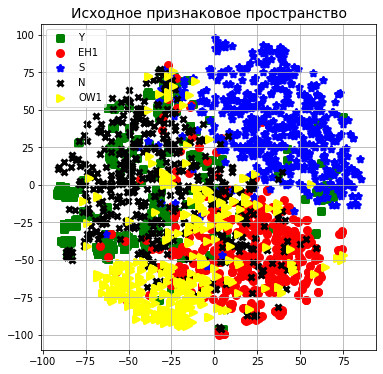

In [24]:
plt.figure(figsize=(6, 6))
plot_tsne(
    plt, X_emb, y, 
    labels=labels_yes_no, 
    num_points=500, # кол-во точек для отрисовки из каждого класса
    title="Исходное признаковое пространство"
    )

> ### **tsne с учетом обрезки признаков по краям**

Будем выкидывать определенное количество фонем на границах слева и справа, тем самым минимизируя их влияние

  0%|          | 0/6 [00:00<?, ?it/s]

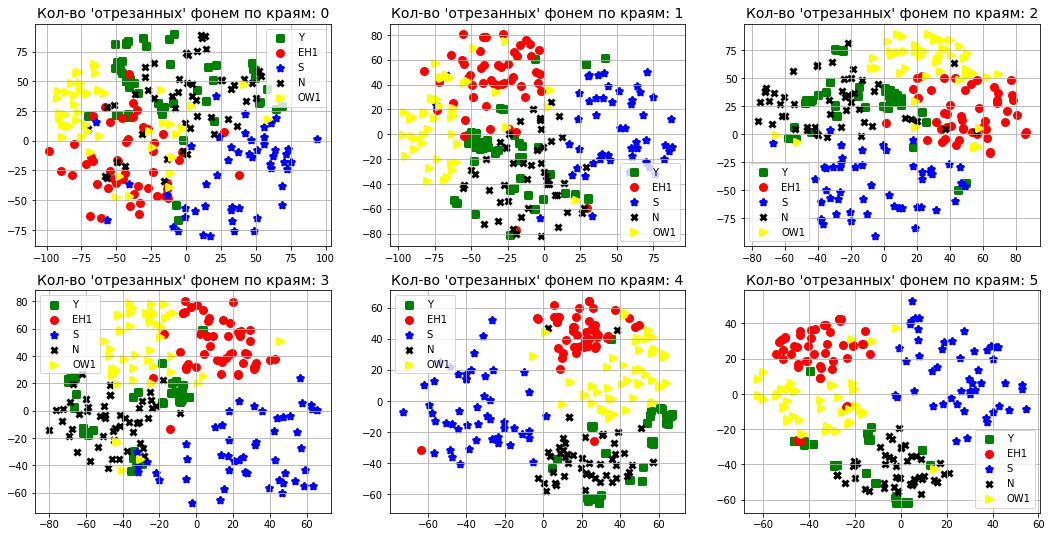

In [27]:
plt.figure(figsize=(18, 9))

for skip in tqdm(range(0, 6)):

    phones_dict_new = get_phones_dict(phones=phones_yes_no, skip=skip)
   
    # формирование матрицы признаков и веткора разметки
    X, y = get_xy(
        phones=phones_yes_no, phones_dict=phones_dict_new, labels=labels_yes_no
    )
    # TSNE
    X_emb = tsne_pipeline(X, use_scaler=True)

    # отрисовка результатов
    plot_tsne(
        plt, X_emb, y, 
        labels=labels_yes_no,
        num_points=50,  # кол-во точек для отрисовки из каждого класса
        title=f"Кол-во 'отрезанных' фонем по краям: {skip}",
        subplot=int(f"23{skip+1}")
    )

Отрисуем для всех оставшихся точек

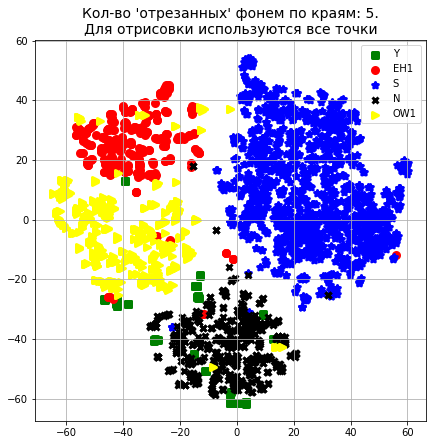

In [32]:
# отрисовка результатов
plt.figure(figsize=(7, 7))
plot_tsne(
    plt, X_emb, y, 
    labels=labels_yes_no,
    title=f"Кол-во 'отрезанных' фонем по краям: {skip}.\nДля отрисовки используются все точки",
)

### **Ответ**:
В данном задании было сделано следующее: 
* Применен алгоритм **tsne** для снижения размерности признакового пространства с 13 до 2.
* Первоначально этот алгоритм применялся на исходном признаковом описании (то, которое мы получили путем объедения всех признаков всех интересующих нас фонем). Получилось достаточно смазано, хотя кластер фонемы **S** стоит уверенным "особняком" относительно других кластеров. Остальные кластеры тоже визуально можно отделить друг от друга, но они больше перемешаны (на субъективный визуальный взгляд).
* Далее я попробовал просто выкидывать признаковое описание пограничных фонем: по одной справа и слева, по две справа и слева и т.д. до 5. На графиках выше видно, что кластеры уже более четко отделяются друг от друга (по мере увеличения количества отбрасываемых фонем по краям). Хотя кластер фонемы **Y** все равно достаточно сильно пересекается с кластером фонемы **N**. На каждом графике отрисовывалось по 50 случайных точек из каждого класса (т.к. они не сбалансированы). 
* Минус последнего подхода, что мы просто выкидываем признаки. Но как понял, цель этого задания - чисто визуальная, определить границы кластеров.
* Пробовал еще окно Хэмминга применить на весь участок непрерывного следования нужной фонемы. Думал, что это решит нашу проблему: по границам признаки обнуляются, по центру - нет. Но стало хуже:) Вероятно, это связано с тем, что мы в данном случае кардинально меняем признаковое описание - одни заменяем на другие.
* *Из нереализованного:* Можно еще увеличить количество файлов для генерации признаков. Это увеличит количество признаков для каждой фонемы и, вероятно, решит проблему того, что один класс для фонемы **Y** плохо отделим. Потому что для данной фонемы меньше всего признаков. И, вероятно, при использовании алгоритма **tsne** они может как-то теряются.
* *Из нереализованного:* Можно для каждой фонемы брать одинаковое количество признаков и затем подавать на вход **tsne**. Непонятно правда, как понимать, какие признаки лучше взять, а какие оставить. Попробовал первые 50 брать, картина не сильно поменялась. Но может хитрее как-то делать.

### <b>Задание №2</b> (5 баллов):
Заменить модель среднего значения фонемы на GMM. Количестов смесей для каждой фонемы можно выставить в 3. Теперь вместо расстояния мы будем измерять вероятность принадлежности кадра признаков к GMM модели фонемы, находящейся в конкретном узле графа. Чтобы использовать это значение в парадигме нашего алгоритма, в качестве дистанции нужно брать значение -log(x), где x -- предсказанная вероятность. Тогда чем выше вероятность, тем такая импровизированная дистанция будет меньше. Ссылка на питоновскую реализацию GMM -- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html.

Что стало с качеством распознавания на двух тестах?

### **Ответ**:

* Код для реализации GMM модели для каждой фонемы приведен в ячейке 25
* Акустическую модель на основе GMM модели: в ячейке 27

Результаты работы системы распознавания слов YES/NO и цифр приведены в таблице ниже (для 100 файлов):

|Акустическая модель|Распознавание YES_NO||Распознавание цифр||
|-|-|-|-|-|
|
||**WER, %**|**Время, с**|**WER, %**|**Время, с**|
|**На основе среднего значения**|**20**|0.06|**70**|0.33|
| | | | | |
|**GMM модель**, *кол-во смесей: 2*|-|-|-|-|
|- Ковариационная матрица: диагональная|**0**|1.3|**20**|19|
|- Ковариационная матрица: полная|**20**|1.2|**30**|21.5|
| | | | | |
|**GMM модель**, *кол-во смесей: 3*|-|-|-|-|
|- Ковариационная матрица: диагональная|**10**|1.3|**20**|20|
|- Ковариационная матрица: полная|**10**|1.4|**35**|24|
| | | | | |
|**GMM модель**, *кол-во смесей: 4*|-|-|-|-|
|- Ковариационная матрица: диагональная|**10**|1.3|**25**|20|
|- Ковариационная матрица: полная|**0**|1.4|**35**|25.5|
| | | | | |
|**GMM модель**, *кол-во смесей: 5*|-|-|-|-|
|- Ковариационная матрица: диагональная|**10**|1.4|**25**|20|
|- Ковариационная матрица: полная|**20**|1.6|**45**|28|


**Выводы** (*при использовании 100 файлов для генерации признаков*):
- качество системы распознавания улучшилось при использовании **GMM моделей**: для распознавания слов **YES/NO** удалось достичь **WER=0%**, для цифр - **WER=20%**
- при использовании **полной** ковариационной матрицы качество хуже получилось, чем при использовании **диагональной**
- время работы модели на основе **GMM** на порядок медленее, чем на основе средних, но и качество лучше
- при использовани **2 или 3 смесей** для **GMM** моделей - качество лучше всего получилось, дальше оно начинает ухудшаться (если смотреть на распознавание цифр)
- *из нереализованного*: можно еще  поварьировать **random_state** - вероятно, может повлиять на точность GMM моделей (судя из курса по EM-алгоритмам)

**Выводы**  (*при использовании 1000 файлов для генерации признаков*):
- удалось достичь качества **WER=0%** для распознавания слов и **WER=5%** для распознавания цифр при использовании 3 Гауссовых смесей для каждой фонемы. Результат работы можно видеть в ячейках **32** и **33**.